<a href="https://colab.research.google.com/github/dhelms1/plant_pathology/blob/main/plant_pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Pathology Project**
---
Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

In this project, we will use images of apple leaves to train a Neural Network that can correctly identify and diagnose infected/healthy leaves for one another (the disease types are listed below). The model will be evaulated based on the average of the individual AUCs of each predicted column. We will aim for above a 95% accuracy, incoporating transfer learning using the framework PyTorch.

### **Project Outcome Goals**
---
1) Accurately classify a given image from testing dataset into different diseased category or a healthy leaf.  
2) Accurately distinguish between many diseases, sometimes more than one on a single leaf.  
3) Deal with rare classes and novel symptoms.  
4) Address depth perception—angle, light, shade, physiological age of the leaf.  
5) Incorporate expert knowledge in identification, quantification, and guiding computer vision to search for relevant features during learning.

### **Disease Types (Labels)**
---
- `healthy`: no diseases present
- `multiple_diseases`: combination of multiple disease
- `rust`: apple rust is present on the leaf
- `scab`: apple scab is present on the leaf

## **Import Modules**
We will want to begin by importing the modules necessary to run the project. Along with this, we will want to setup the device to be used for training during the model. If 'cuda' is printed, we are using a GPU. Otherwise, training will be done on the CPU (at a slower rate).

*Note that if running this outside of Google Colab on a personal machine, the GPU must be Nvidia in order to use CUDA, otherwise CPU will be selected.*

In [1]:
!pip install efficientnet_pytorch # install efficientnet

In [38]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import Image
from time import time
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

plt.style.use('seaborn-dark')
plt.rcParams['font.size'] = 12
palette = sns.color_palette('Paired', 10)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## **Format Images**

The dataset from [Kaggle](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data) comes in one directory, with training and testing images mixed together. We will take the following steps in order to get them in the correct format to be read into the [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) method:  

- Create directories for the train, valid, and test sets.
- Create new subdirectories for each disease label (label to disease names saved as dictionary for later use).
- Read in the labels for the train and test sets.  
- Split the data into train and valid sets (80/20).
- Get image names for each disease type and save to seperate variables.
- Move the images to the correct directories within the image folder for each set.

*Note: you must mount Google Drive in order to read in images from directories.*

#### **Create Directories**

In [ ]:
# Create directories for the Train and Test images
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Train')
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Test')
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Valid')

In [ ]:
# Create label subdirectories to move images into (1,2,3,4)
for dir_num in range(1,5):
  os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/' + dir_num)
  os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Valid/' + dir_num)

In [ ]:
# Create dictionary to map from created folder labels to original category names
cat_to_name = {'1': 'healthy',
               '2': 'multiple_diseases',
               '3': 'rust',
               '4': 'scab'}          

#### **Read in Labels**

In [4]:
# Read in csv's containing the image_id and the disease features
test_labels = pd.read_csv('drive/My Drive/Colab Notebooks/Plant Pathology/test.csv') # df of image numbers
train_labels = pd.read_csv('drive/My Drive/Colab Notebooks/Plant Pathology/train.csv')
submission_labels = pd.read_csv('drive/My Drive/Colab Notebooks/Plant Pathology/sample_submission.csv')

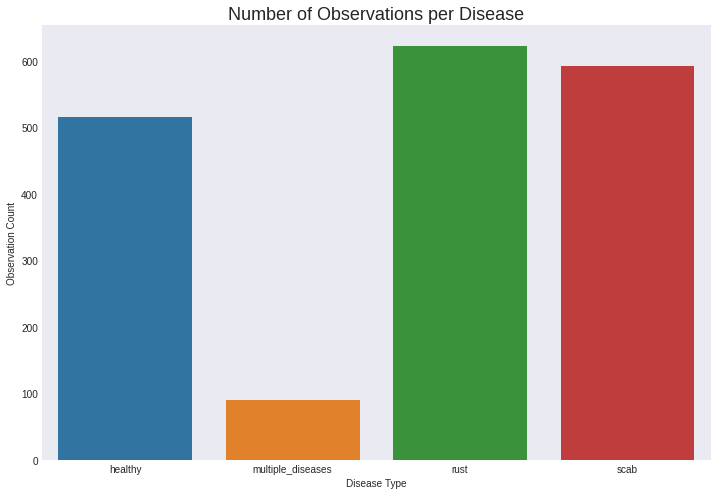

In [ ]:
class_count = train_labels.drop('image_id', axis=1).sum()
plt.figure(figsize=(12,8))
sns.barplot(x=class_count.index, y=class_count.values)
plt.title('Number of Observations per Disease', fontsize=18)
plt.xlabel('Disease Type')
plt.ylabel('Observation Count')
plt.show();

#### **Splitting Data**

We will want to split our data into training and validation sets to be used later. It's easier to do this by splitting the dataframe with `image_id` and `labels` now and then relocating the corresponding images to their correct subdirectories later.

In [ ]:
# Split training data into train and validation sets
train_set, valid_set = train_test_split(train_labels, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Get train image names for each disease type
healthy_train = train_set.image_id[train_set.healthy == 1].values
multi_train = train_set.image_id[train_set.multiple_diseases == 1].values
rust_train = train_set.image_id[train_set.rust == 1].values
scab_train = train_set.image_id[train_set.scab == 1].values

In [ ]:
# Get valid image names for each disease type
healthy_valid = valid_set.image_id[valid_set.healthy == 1].values
multi_valid = valid_set.image_id[valid_set.multiple_diseases == 1].values
rust_valid = valid_set.image_id[valid_set.rust == 1].values
scab_valid = valid_set.image_id[valid_set.scab == 1].values

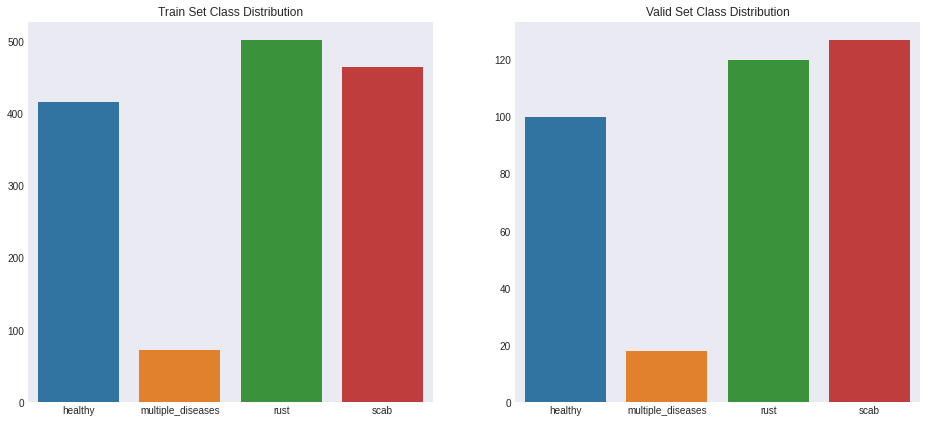

In [ ]:
# Visualize the number of observations in each set for each disease type
train_count = train_set.drop('image_id', axis=1).sum()
valid_count = valid_set.drop('image_id', axis=1).sum()

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Train Set Class Distribution')
sns.barplot(x=train_count.index, y=train_count.values)
ax1 = plt.subplot(1,2,2)
ax1.set_title('Valid Set Class Distribution')
sns.barplot(x=valid_count.index, y=valid_count.values)
plt.show();

#### **Move Images to Subdirectories**

We will create a function that moves images from their current directory to a specified subdirectory and the correct label folder.

In [ ]:
def relocate_image(img_array, split, label_num):
  '''
  Move training  and validation images from current directories to their new labeled 
  subdirectories to be used for the ImageFolder.
  '''
  for img in img_array:
    curr_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + img + '.jpg'
    new_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + split + '/' + label_num + '/' + img + '.jpg'
    Path(curr_path).rename(new_path)
  return None

In [ ]:
# Move Training images from current directories to their new subdirectories
relocate_image(healthy_train, 'Train', '1')
relocate_image(multi_train, 'Train', '2')
relocate_image(rust_train, 'Train', '3')
relocate_image(scab_train, 'Train', '4')

In [ ]:
# Move Validation images from current directories to their new subdirectories
relocate_image(healthy_valid, 'Valid', '1')
relocate_image(multi_valid, 'Valid', '2')
relocate_image(rust_valid, 'Valid', '3')
relocate_image(scab_valid, 'Valid', '4')

In [ ]:
# Move Testing images from current directory to new folder
for img in test_labels.image_id.values:
  curr_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + img + '.jpg'
  new_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/Test/' + img + '.jpg'
  Path(curr_path).rename(new_path)

## **Read in Images**

Now that we have the images in the correct directory format, we want to read the images in using the *ImageFolder* function discussed above. We will want to perform augmentation on the training sets but not on the validation set. 

Note that we will have to read in the test images in a different way, since *ImageFolder* expects subfolders with labels, but the test images are unlabeled. We can do this by defining a custom [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) to load our data.


In [5]:
data_dir = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/'
BATCH_SIZE = 8 # 32 for MobileNet

In [59]:
train_transforms = transforms.Compose([transforms.RandomRotation(5),
                                       transforms.Resize(448),                                    
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),                                      
                                       transforms.ColorJitter(0.2, 0.3, 0.4, 0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485 , 0.456 , 0.406],
                                                            [0.229 , 0.224 , 0.225])])

val_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + 'Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + 'Valid', transform=val_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)

#### **Testing Dataset**

Now, we will create a custom Dataset that can be used to transform the testing images in the same manner as the validation set. We will also write a function to display a subsection of the testing images so we can compare them to the directory manually and ensure they were correctly read in.

In [35]:
class TestingDataset(torch.utils.data.Dataset):
    def __init__(self, main_dir, test_labels):
      self.main_dir = main_dir
      self.labels = test_labels
      self.transform = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
      self.dir_labels = os.listdir(main_dir)

    def __len__(self):
      return len(self.dir_labels)

    def __getitem__(self, index):
      img_path = os.path.join(self.main_dir, self.labels[index] + '.jpg')
      image = Image.open(img_path).convert('RGB')
      image = self.transform(image)
      return image


In [36]:
test_data = TestingDataset(data_dir + 'Test', test_labels.image_id.values)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

#### **Visualize Images**

We will create a function that allows us to output images in our dataloader objects.

In [39]:
def imshow(image, ax, split_type, title_num):
    image = np.asarray(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1) # Otherwise image looks like noise
    ax.imshow(image) # show image
    ax.set_title(f'{split_type} Image {title_num}')
    ax.set_xticklabels('')
    ax.set_yticklabels('')
  
    return None

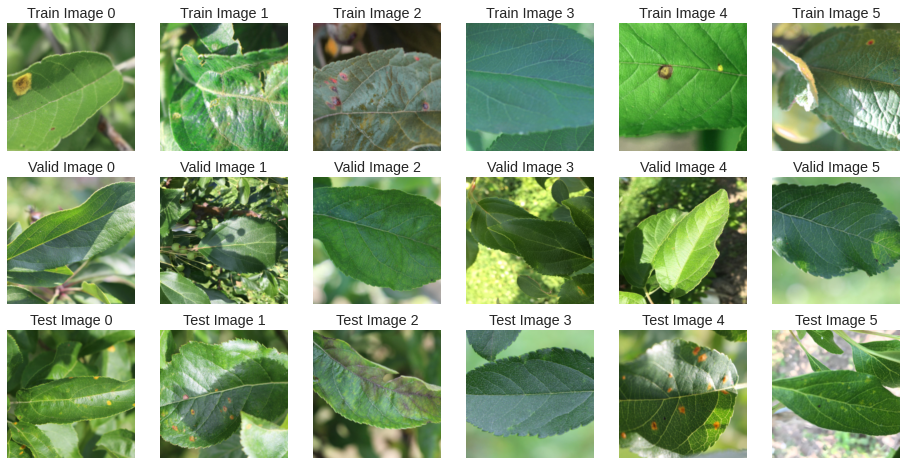

In [60]:
test_images = next(iter(testloader)) # make testloader a callable object
train_images, _ = next(iter(trainloader)) # make trainloader a callable object
valid_images, _ = next(iter(validloader)) # make validloader a callable object

# Plot first 6 images in each dataloader
fig, axs = plt.subplots(3,6, figsize=(16,8))
for col, img in enumerate(range(6)):
  imshow(train_images[img], axs[0, col], 'Train', col)
  imshow(valid_images[img], axs[1, col], 'Valid', col)
  imshow(test_images[img], axs[2, col], 'Test', col)

## **Modeling**

*Fill in...*

#### **Create Training Functions**

In [30]:
def create_model():
  '''
  Create a model using a pretrained architecture. Turn off training for all layers
  and define a new classifier that matches the number of diseases.
  '''
  model = EfficientNet.from_pretrained('efficientnet-b5')

  input_size = model._fc.in_features

  model._fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, 4)),
                                         ('output', nn.LogSoftmax(dim=1))]))
  
  return model  

In [31]:
def create_hub_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  model.classifier = nn.Sequential(OrderedDict([('dropout1', nn.Dropout(p=0.2)),
                                                ('fc1', nn.Linear(1280, 4)),
                                                ('output', nn.LogSoftmax(dim=1))]))
  return model

In [32]:
def train_model(model, epochs, trainloader, validloader):
  '''
  Train a model for a given number of epochs. We will also evaluate the accuracy 
  for validation set. Return the training and validation set accuracy and loss 
  to be plotted.
  '''
  train_loss = 0
  train_acc = 0
  train_loss_hist = []
  val_loss_hist = []
  train_acc_hist = []
  val_acc_hist = []
  print(f'Training on {device} using {model.__class__.__name__} architecture...\n')
  for epoch in range(epochs):
    start = time()
    for images, labels in trainloader: # Training
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      log_ps = model.forward(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(k=1, dim=1)
      equals = (top_class == labels.view(*top_class.shape))
      train_acc += torch.mean(equals.type(torch.FloatTensor)).item()

    with torch.no_grad(): # Validation 
      val_loss = 0
      val_acc = 0
      model.eval()
      for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)

        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        val_loss += loss.item()

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(k=1, dim=1)
        equals = (top_class == labels.view(*top_class.shape))
        val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
      
      end = time()
      train_loss_hist.append(train_loss/len(trainloader))
      train_acc_hist.append(train_acc/len(trainloader))
      val_loss_hist.append(val_loss/len(validloader))
      val_acc_hist.append(val_acc/len(validloader))

      print(f'Epoch {epoch+1}/{epochs}... '
            f'{round(end-start, 1)}s... '
            f'Train Loss: {train_loss/len(trainloader):.3f}... '
            f'Train Accuracy: {train_acc/len(trainloader):.3f}... '
            f'Val Loss: {val_loss/len(validloader):.3f}... '
            f'Val Accuracy: {val_acc/len(validloader):.3f}')
      train_loss = 0
      train_acc = 0
      model.train()
  return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

In [63]:
def plot_history(train_stat, val_stat, epochs, s_type):
  '''
  Plot history of model training and validation stats.
  '''
  sns.set_style('whitegrid')
  sns.lineplot(x=np.arange(1, epochs+1), y=train_stat)
  sns.lineplot(x=np.arange(1, epochs+1), y=val_stat, color='orange')
  plt.xticks(ticks=np.arange(1, epochs+1))
  plt.legend(['train', 'valid'], frameon=True)
  plt.title(f'{s_type} over {epochs} epochs')
  plt.xlabel('Epoch')
  plt.ylabel(s_type)
  return None

#### **EfficientNet b5 Model Training**

---

Loaded pretrained weights for efficientnet-b5
Training on cuda using EfficientNet architecture...

Epoch 1/30... 279.7s... Train Loss: 0.857... Train Accuracy: 0.683... Val Loss: 0.695... Val Accuracy: 0.788
Epoch 2/30... 176.1s... Train Loss: 0.716... Train Accuracy: 0.755... Val Loss: 0.988... Val Accuracy: 0.715
Epoch 3/30... 175.9s... Train Loss: 0.640... Train Accuracy: 0.790... Val Loss: 1.354... Val Accuracy: 0.616
Epoch 4/30... 175.4s... Train Loss: 0.555... Train Accuracy: 0.823... Val Loss: 0.425... Val Accuracy: 0.875
Epoch 5/30... 175.4s... Train Loss: 0.557... Train Accuracy: 0.822... Val Loss: 0.586... Val Accuracy: 0.837
Epoch 6/30... 175.4s... Train Loss: 0.514... Train Accuracy: 0.832... Val Loss: 0.278... Val Accuracy: 0.917
Epoch 7/30... 175.9s... Train Loss: 0.513... Train Accuracy: 0.845... Val Loss: 0.292... Val Accuracy: 0.918
Epoch 8/30... 175.8s... Train Loss: 0.466... Train Accuracy: 0.847... Val Loss: 0.300... Val Accuracy: 0.905
Epoch 9/30... 175.7s... Train

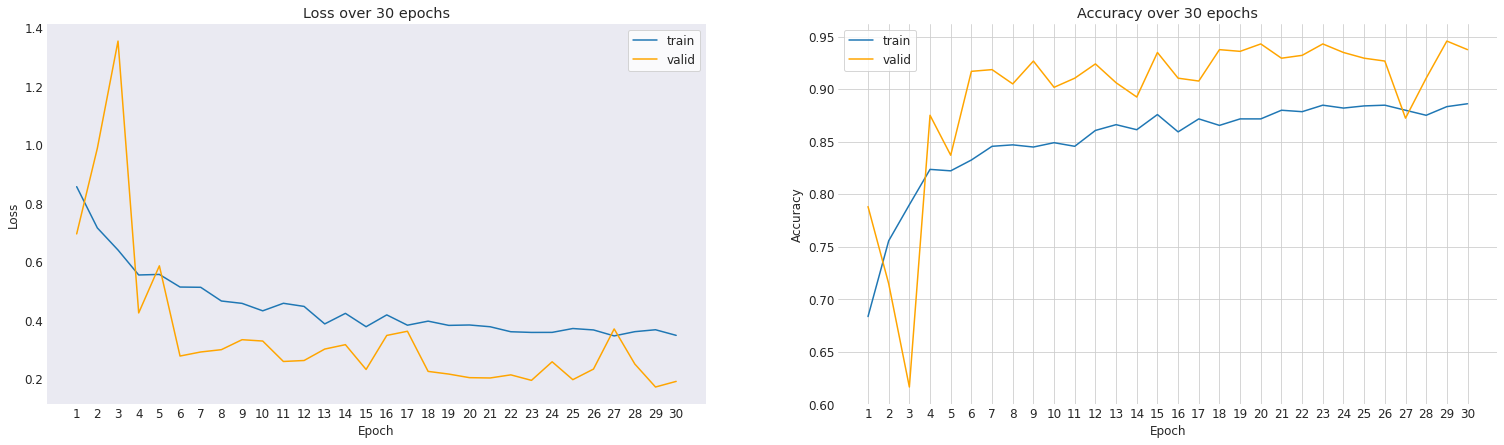

In [64]:
# EfficientNet Model
model = create_model()
model.to(device);

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30

# Train model
train_loss, train_acc, val_loss, val_acc = train_model(model, epochs, trainloader, validloader)

# Plot loss and accuracy
plt.figure(figsize=(26,7))
ax1 = plt.subplot(1,2,1)
plot_history(train_loss, val_loss, epochs, 'Loss')
ax2 = plt.subplot(1,2,2)
plot_history(train_acc, val_acc, epochs, 'Accuracy')
plt.show();

#### **MobileNet v2 Model Training**

---


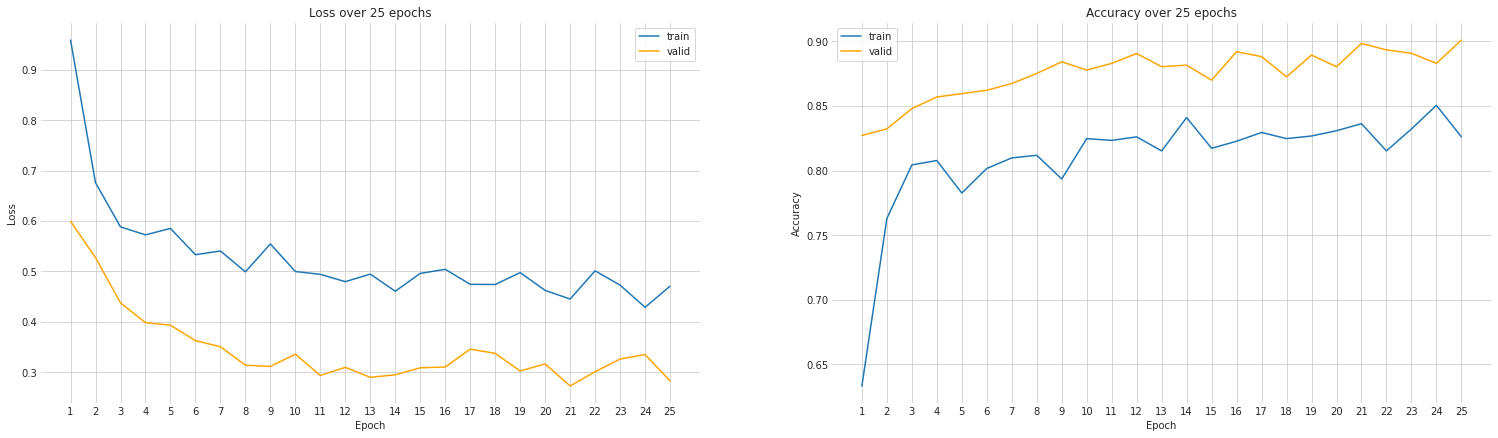

In [ ]:
# Create MobileNet model and move to current device
model = create_hub_model()
model.to(device);

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model2.classifier.parameters(), lr=0.001)

epochs = 25

# Train model
train_loss, train_acc, val_loss, val_acc = train_model(model, epochs, trainloader, validloader)

# Plot loss and accuracy
sns.set_style('whitegrid')
plt.figure(figsize=(26,7))
ax1 = plt.subplot(1,2,1)
plot_history(train_loss, val_loss, epochs, 'Loss')
ax2 = plt.subplot(1,2,2)
plot_history(train_acc, val_acc, epochs, 'Accuracy')
plt.show();

#### **Saving/Loading Model**

Save model and optimizer after training (currently set up for the MobileNet model). We will also write a function to load the checkpoint dictionary to continue training or use model for predictions. 

In [69]:
checkpoint = {'state_dict': model.state_dict(),
              'opt_state': optimizer.state_dict(),
              'classifier': model._fc
              }

torch.save(checkpoint, 'drive/My Drive/Colab Notebooks/Plant Pathology/checkpoint_96.pth')             

In [70]:
def load_checkpoint(model, optimizer, check_path):
  '''
  Pass a loaded model and a filepath to the saved checkpoint
  to reload the saved model. Note that parameters will be need
  to set for "requires_grad = False" outside of this function.
  '''
  checkpoint = torch.load(check_path)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model._fc = checkpoint['classifier'] # change _fc to classifier for MobileNet
  model.load_state_dict(checkpoint['state_dict'])
  model.to(device)
  optimizer.load_state_dict(checkpoint['opt_state'])
  return model, optimizer

In [72]:
# Load saved Efficient Net b5 model parameters and optimizer
loaded_model = EfficientNet.from_pretrained('efficientnet-b5')
check_pth = 'drive/My Drive/Colab Notebooks/Plant Pathology/checkpoint_96.pth'
optimizer = optim.Adam(loaded_model.parameters(), lr=0.001) # parameters will be reset

efficient_b5, optimizer = load_checkpoint(loaded_model, optimizer, check_pth)

Loaded pretrained weights for efficientnet-b5


#### **Predicting and Creating Submission**

Create a function to predict disease type for the unlabeled testing images. We also want to create a function that will create a dataframe for these predictions and save in the format that kaggle wants. [Click here](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview/evaluation) to see the format for the submission csv file.

In [65]:
def predict(model, testloader):
  '''
  Given a model and testloader, go through each batch and predict the probabilities for each disease type.
  Return the predictions in a (1821, 4) list
  '''
  predictions = []
  model.eval()
  with torch.no_grad():
    for images in testloader: # no labels
      images = images.to(device) 
      log_ps = model.forward(images) # get log probabilities from output
      ps = torch.exp(log_ps) # get probabilities
      probs = ps.data.cpu().tolist() # move to cpu and convert to list
      [predictions.append(p) for p in probs] # append each individual image predictions
  model.train()
  return predictions

In [66]:
def create_submission(preds, sub_num):
  ''' Create a dataframe for the submission file and save to drive. '''
  submission = pd.DataFrame(data=preds, columns=submission_labels.drop('image_id', axis=1).columns)
  submission.insert(0, 'image_id', submission_labels.image_id.values)
  submission.to_csv(f'drive/My Drive/Colab Notebooks/Plant Pathology/submission{sub_num}.csv', index=False)
  return submission

In [67]:
start = time()

preds = predict(model, testloader)

print(f'Prediction Time: {round(time()-start, 2)}s')

Prediction Time: 1226.3s


In [68]:
# Create submission csv for model
submission_df = create_submission(preds, '3')
submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,9.657566e-03,0.082044,9.076825e-01,0.000616
1,Test_1,3.372262e-03,0.031170,9.651097e-01,0.000348
2,Test_2,3.182380e-07,0.000377,8.162804e-07,0.999622
3,Test_3,9.977346e-01,0.000628,1.601898e-03,0.000036
4,Test_4,7.926963e-04,0.004855,9.943429e-01,0.000009


#### **Model Accuracy**

Tracking for accuracy results after submitting csv file to Kaggle:

---


> Submission.csv | Model Architecture | Private Score | Public Score | Public Leaderboard
> --- | --- | --- | --- | ---
> 1 | MobileNet v2 | 89.78% | 92.06% | 934
> 2 | EfficientNet b5 | 92.62% | 92.20% | 927
> 3 | EfficientNet b5 | 92.9% | 95.90% | 485



EfficientNet model (submission 3) was trained for 10 epochs longer than submission 2 model (30 epochs for latest model). It had around 4% greater accuracy on public score compared to MobileNet. At the current state, EfficientNet is the slightly better model. However, the EfficientNet model took around 10x longer to predict than MobileNet, so keep this in mind if prediction time is a factor.
